<a href="https://colab.research.google.com/github/sgoffe/garbage-gang/blob/main/Garbage_Gang_Artificial_Neural_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os


# Model Definition

In [ ]:
# Define the AlexNet model
def AlexNet(input_shape, num_classes):
    model = models.Sequential([
        # 1st Convolutional Layer
        layers.Conv2D(96, kernel_size=(11,11), strides=(5,5), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        layers.Dropout(0.25),  # dropout with rate 0.25


        # 2nd Convolutional Layer
        layers.Conv2D(256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        layers.Dropout(0.25),

        #3rd Convolutional Layer
        layers.Conv2D(256, kernel_size=(3,3), strides=(2,2), activation='relu', padding="same"),
        layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        layers.Dropout(0.25),

        # Passing it to a Fully Connected layer
        layers.Flatten(),

        # Fully Connected Layer
        layers.Dense(2048, activation='relu'),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# input shape and number of classes
input_shape = (384, 512, 3)
num_classes = 6

# Create AlexNet model
danfavs_model = AlexNet(input_shape, num_classes)

# Compile
danfavs_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# model summary
danfavs_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 101, 96)       34944     
                                                                 
 batch_normalization (Batch  (None, 75, 101, 96)       384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 50, 96)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 37, 50, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 50, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 37, 50, 256)       1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Images

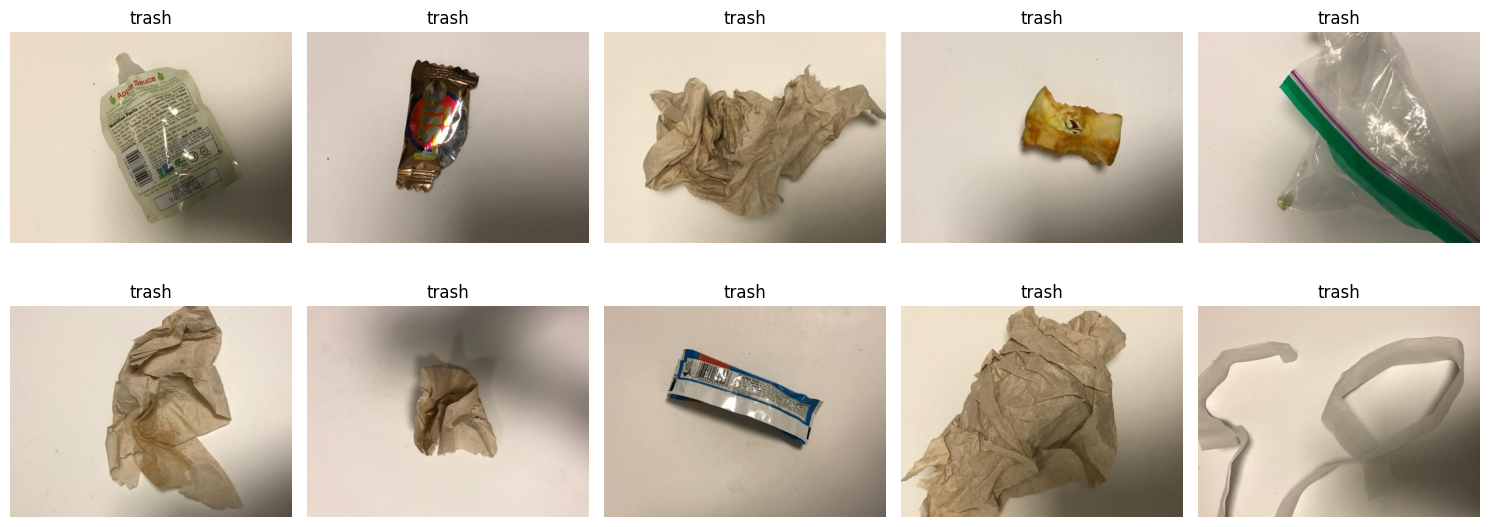

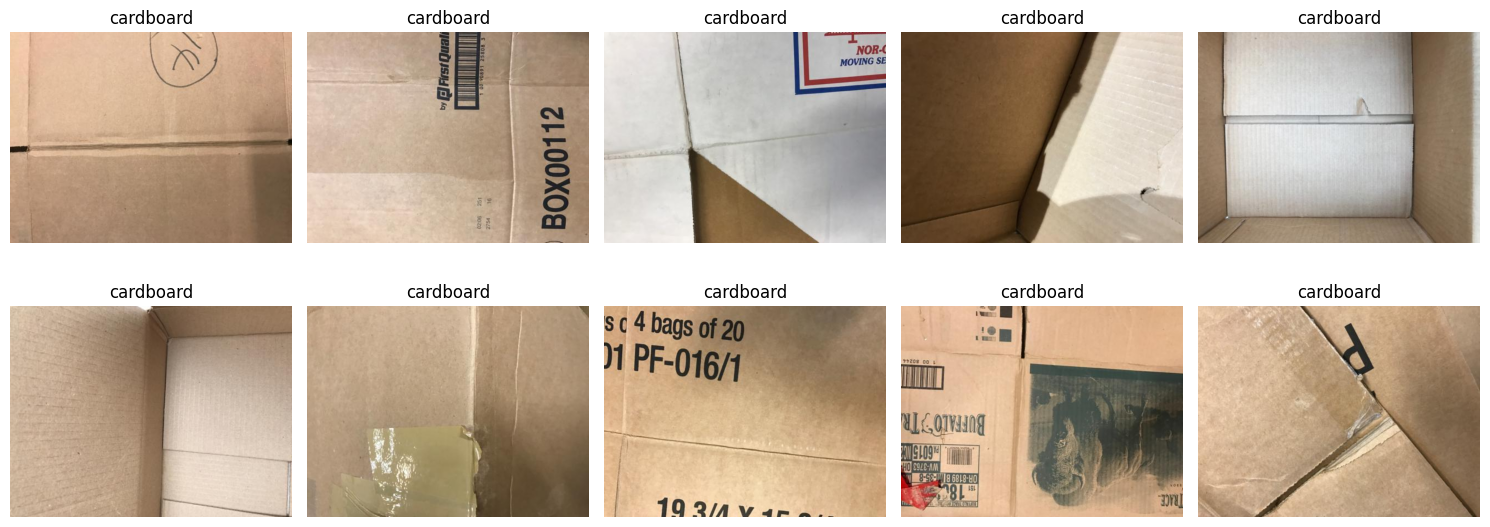

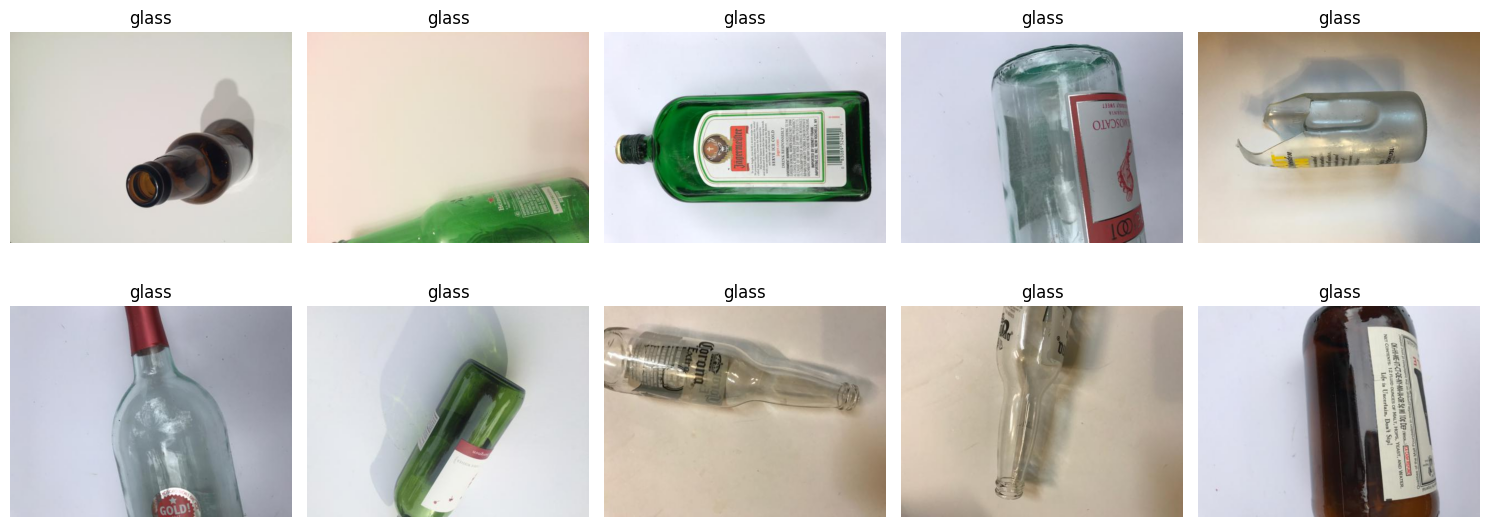

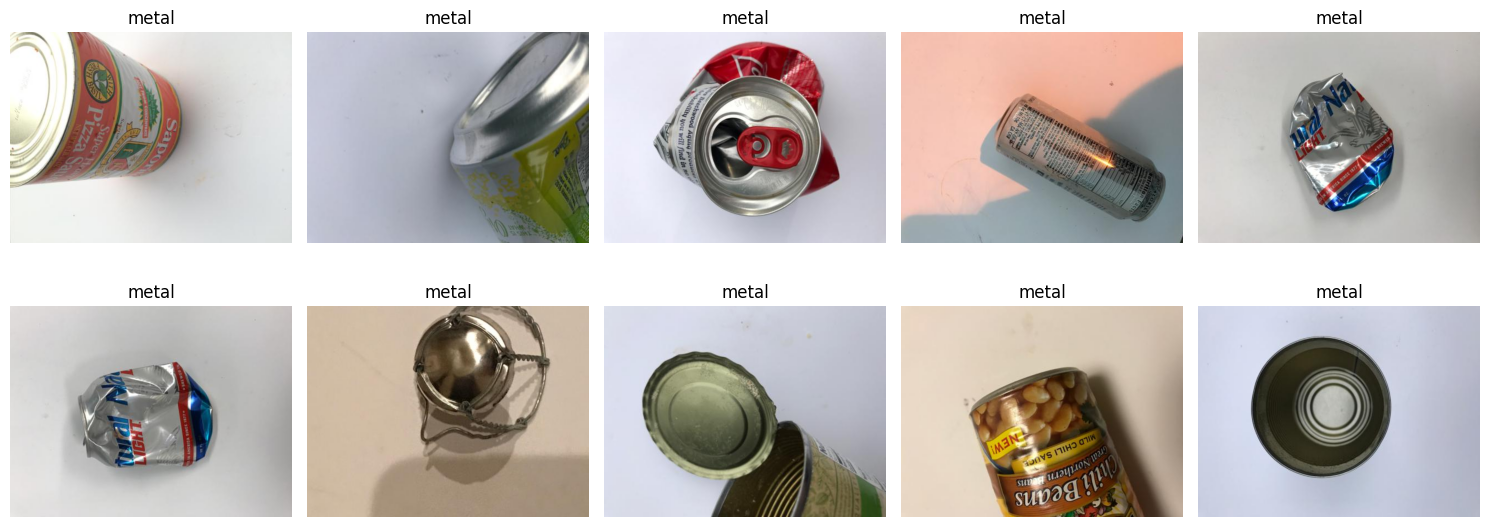

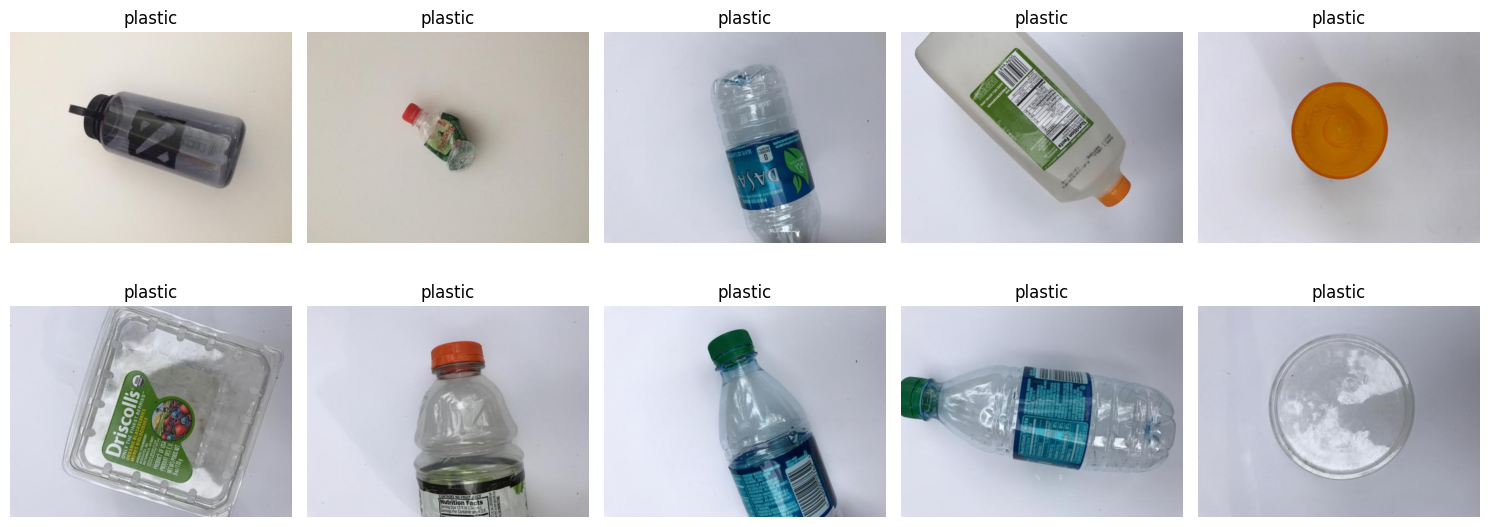

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to the dataset directory
dataset_dir = '/content/drive/My Drive/Colab Notebooks/trash_data'

# List of classes
classes = ["trash", "cardboard", "glass", "metal", "plastic", "paper"]

# Function to plot images with their labels
def plot_images(class_name):
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i in range(10):
        image_path = os.path.join(class_dir, images[i])
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Plot example images for each class
for class_name in classes:
    plot_images(class_name)

def count_images_per_class_from_paths(dataset_path, classes):
    class_counts = {class_name: 0 for class_name in classes}
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.exists(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

class_counts = count_images_per_class_from_paths(dataset_dir, classes)
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.title('Dataset Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()


# Histograms

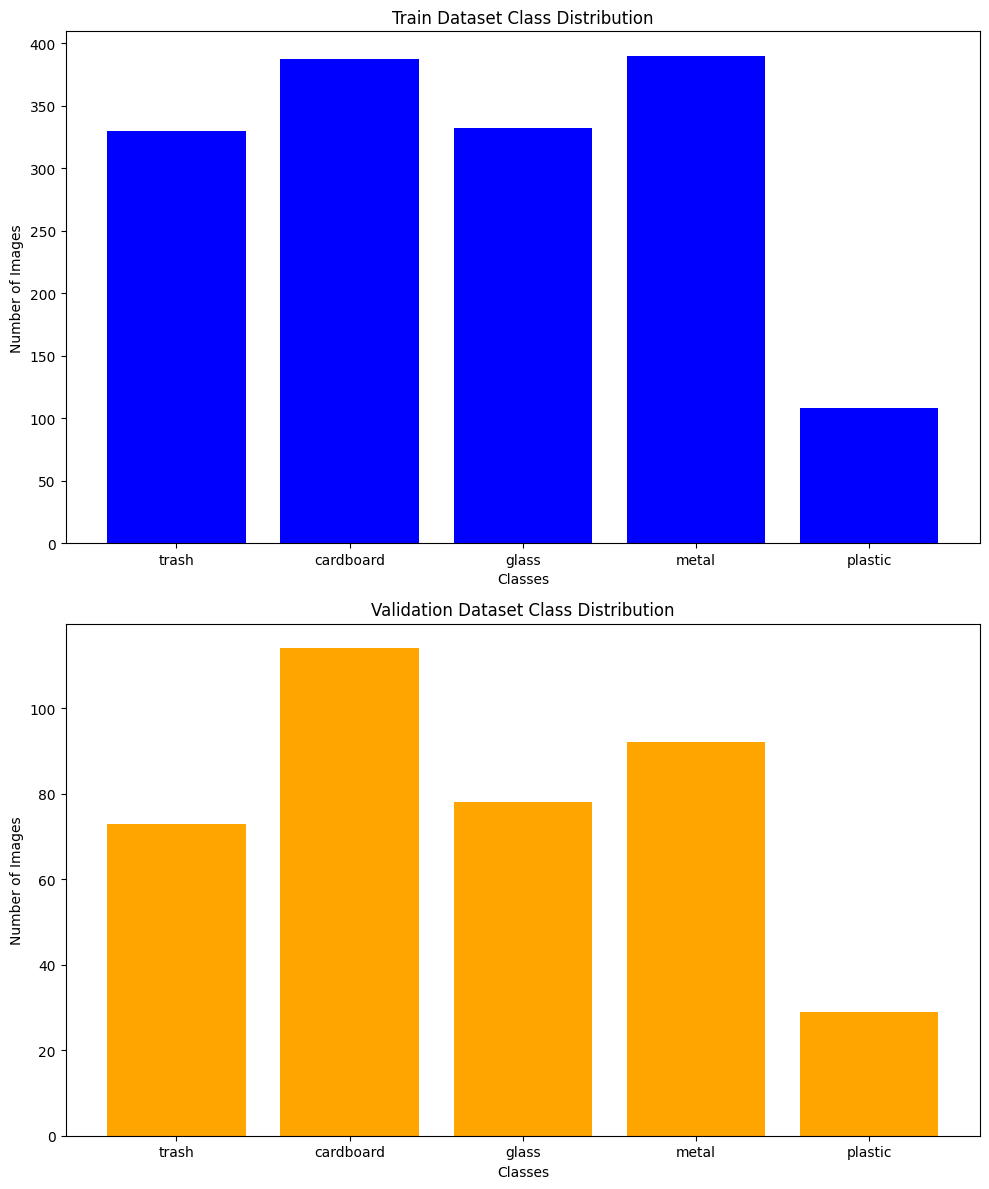

In [ ]:
def count_images_per_class(dataset, classes):
    class_counts = {class_name: 0 for class_name in classes}
    for images, labels in dataset:
        for label in labels:
            class_name = classes[label]
            class_counts[class_name] += 1
    return class_counts

train_class_counts = count_images_per_class(train_ds, classes)
val_class_counts = count_images_per_class(val_ds, classes)
#overall_class_counts = count_images_per_class('/content/drive/My Drive/Colab Notebooks/trash_data', classes)

# Plot histograms
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot histogram for train dataset
axes[0].bar(train_class_counts.keys(), train_class_counts.values(), color='blue')
axes[0].set_title('Train Dataset Class Distribution')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Images')

# Plot histogram for validation dataset
axes[1].bar(val_class_counts.keys(), val_class_counts.values(), color='orange')
axes[1].set_title('Validation Dataset Class Distribution')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

# Baseline Evaluation

In [ ]:
score = danfavs_model.evaluate(val_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 37.63920974731445
Test accuracy: 0.06735751032829285


# Data Split

In [ ]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Function to load images from folder and encode labels
def load_images_from_folder_and_encode(folder):
    images = []
    labels = []
    label_encoder = LabelEncoder()
    for label_folder in os.listdir(folder):
        label = label_folder
        label_folder_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_folder_path):
            for filename in os.listdir(label_folder_path):
                img = cv2.imread(os.path.join(label_folder_path, filename))
                if img is not None:
                    images.append(img)
                    labels.append(label)

    # Encode labels
    encoded_labels = label_encoder.fit_transform(labels)
    return images, encoded_labels, label_encoder

# Path to the folder containing images
folder_path = '/content/drive/My Drive/Colab Notebooks/trash_data'

# Load images and labels, and encode labels
X_train, y_train, label_encoder = load_images_from_folder_and_encode(folder_path)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Print shapes to verify
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# You can also access the mapping of encoded labels to original labels
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print("Label Mapping:", label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Shape of X_train: (1933, 384, 512, 3)
Shape of y_train: (1933,)
Label Mapping: {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'plastic', 4: 'trash'}


# Training

In [ ]:
history = danfavs_model.fit(X_train, y_train, epochs=6, batch_size = 64, validation_data = (X_test, y_test))

Epoch 1/6
25/25 [==============================] - 214s 9s/step - loss: 0.8475 - accuracy: 0.6695 - val_loss: 1.0245 - val_accuracy: 0.6124
Epoch 2/6
25/25 [==============================] - 212s 8s/step - loss: 0.8355 - accuracy: 0.6934 - val_loss: 1.2635 - val_accuracy: 0.5866
Epoch 3/6
25/25 [==============================] - 212s 8s/step - loss: 0.7807 - accuracy: 0.6947 - val_loss: 0.9874 - val_accuracy: 0.6667
Epoch 4/6
25/25 [==============================] - 217s 9s/step - loss: 0.7344 - accuracy: 0.7063 - val_loss: 0.9837 - val_accuracy: 0.6227
Epoch 5/6
25/25 [==============================] - 217s 9s/step - loss: 0.7626 - accuracy: 0.6992 - val_loss: 1.0419 - val_accuracy: 0.6279
Epoch 6/6
25/25 [==============================] - 213s 9s/step - loss: 0.7139 - accuracy: 0.7167 - val_loss: 0.8702 - val_accuracy: 0.6925


In [ ]:
pred = danfavs_model.predict(X_test)

13/13 [==============================] - 16s 1s/step


# History of Fit

Text(0.5, 1.0, 'Training History')

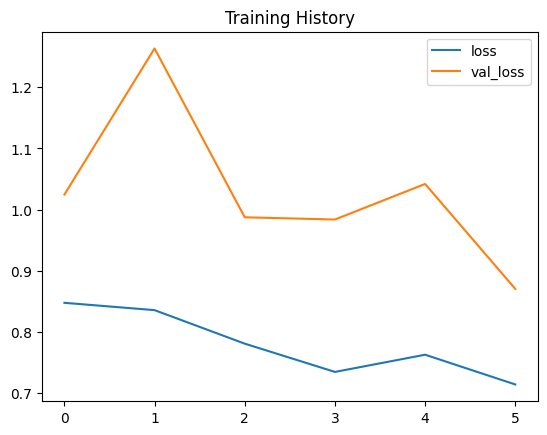

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training History")

# Post Training Evaluation

In [ ]:

score = danfavs_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.870245635509491
Test accuracy: 0.6925064325332642


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted labels for the test set
y_pred = np.argmax(pred, axis=1)

# Calculate
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'pred' is not defined

# Transfer Learning

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [ ]:
#load pretrained base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
#freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
#adding layers on top (our classifier onto base model)
x = base_model.output
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# This creates the full model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
#compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#data prep
from tensorflow.keras.applications.vgg16 import preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)) #augment training data
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

In [ ]:
#train
history = model.fit(train_ds, epochs=6, validation_data=val_ds)

In [ ]:
#eval + predict
score = model.evaluate(val_ds)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

predictions = model.predict(val_ds)

In [ ]:
# history of fit
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training History")

In [ ]:
# confusion matrix

# Get the predicted labels for the test set
y_pred = np.argmax(pred, axis=1)

# Calculate
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
